In [245]:
!pip install medmnist giotto-tda scikit-learn matplotlib seaborn gudhi

python(92807) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [246]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import medmnist
import cv2
import skimage
import shap
import pandas as pd
import xgboost as xgb

import gudhi as gd
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import train_test_split



from gtda.homology import CubicalPersistence
from gtda.diagrams import PersistenceImage
from gtda.diagrams import BettiCurve
from gtda.plotting import plot_diagram
from medmnist import RetinaMNIST

from skimage import feature
import skimage.transform as tf

# Set random seed
#np.random.seed(42)

In [247]:
# Load RetinaMNIST dataset (2D colored retina images)

data = RetinaMNIST(split='train', download=True, size=64)
x_train, y_train = data.imgs, data.labels


# First split only once on full RGB images
X_train, X_test, y_train, y_test = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Train:", X_train.shape, "Test:", X_test.shape)

# Then extract color channels from the split datasets
X_R_train, X_R_test = X_train[..., 0], X_test[..., 0]
X_G_train, X_G_test = X_train[..., 1], X_test[..., 1]
X_B_train, X_B_test = X_train[..., 2], X_test[..., 2]
X_gray_train, X_gray_test = X_train.mean(axis=-1), X_test.mean(axis=-1)

print("Train Red:", X_R_train.shape, "Test Red:", X_R_test.shape)
print("Train Green:", X_G_train.shape, "Test Green:", X_G_test.shape)
print("Train Blue:", X_B_train.shape, "Test Blue:", X_B_test.shape)
print("Train Gray:", X_gray_train.shape, "Test Gray:", X_gray_test.shape)

Train: (864, 64, 64, 3) Test: (216, 64, 64, 3)
Train Red: (864, 64, 64) Test Red: (216, 64, 64)
Train Green: (864, 64, 64) Test Green: (216, 64, 64)
Train Blue: (864, 64, 64) Test Blue: (216, 64, 64)
Train Gray: (864, 64, 64) Test Gray: (216, 64, 64)


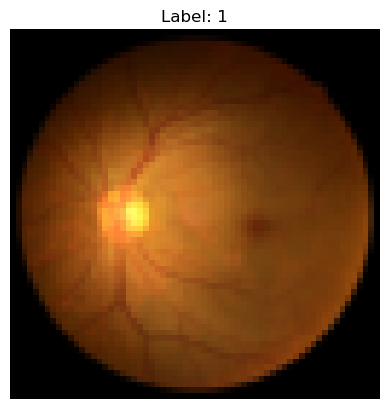

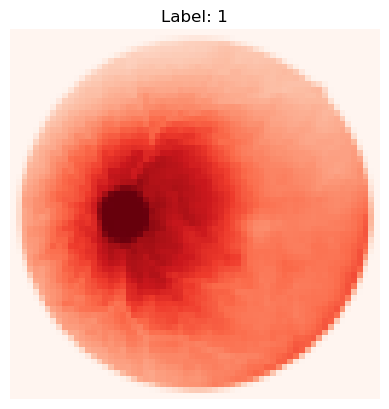

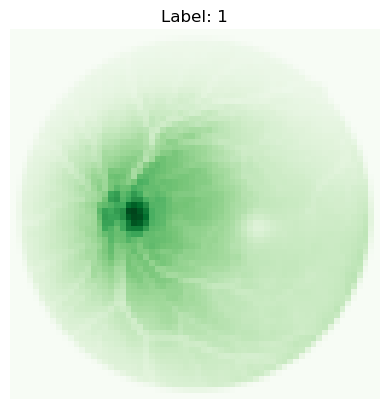

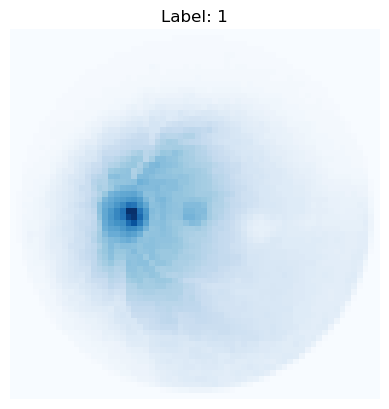

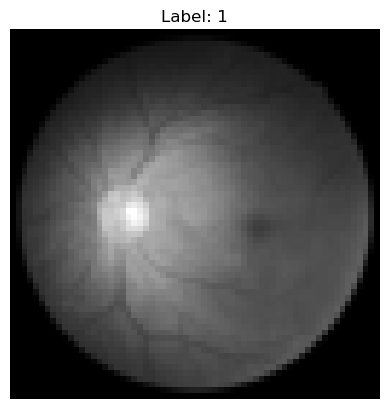

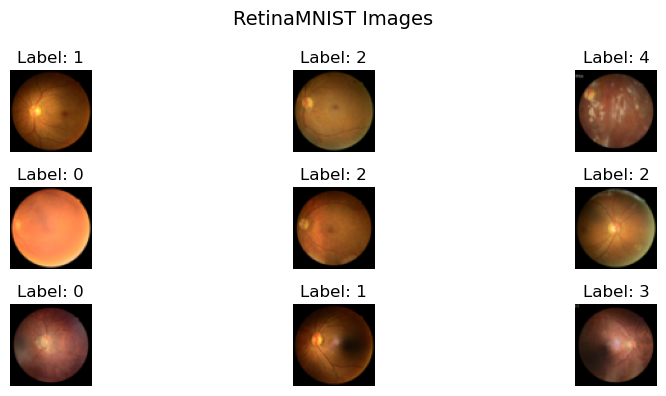

In [206]:
# Choose a single ultrasound image sample from the train set
sample = X_train[0]
sample_R = X_R_train[0]
sample_G = X_G_train[0]
sample_B = X_B_train[0]
sample_gray = X_gray_train[0]

#Plot the sample images

plt.imshow(sample)
plt.title(f"Label: {y_train[0][0]}")
plt.axis('off')
plt.show()

plt.imshow(sample_R, cmap="Reds")
plt.title(f"Label: {y_train[0][0]}")
plt.axis('off')
plt.show()

plt.imshow(sample_G, cmap="Greens")
plt.title(f"Label: {y_train[0][0]}")
plt.axis('off')
plt.show()

plt.imshow(sample_B, cmap="Blues")
plt.title(f"Label: {y_train[0][0]}")
plt.axis('off')
plt.show()

plt.imshow(sample_gray, cmap='gray')
plt.title(f"Label: {y_train[0][0]}")
plt.axis('off')
plt.show()
#Plot more samples from the train set

plt.figure(figsize=(10, 4))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {y_train[i][0]}")
    plt.axis('off')
plt.suptitle("RetinaMNIST Images", fontsize=14)
plt.tight_layout()
plt.show()

In [207]:
# Store Cubical Persistence

cp = CubicalPersistence(homology_dimensions=[0, 1], coeff=3, n_jobs=-1)
cp0 = CubicalPersistence(homology_dimensions=[0], coeff=3, n_jobs=-1)
cp1 = CubicalPersistence(homology_dimensions=[1], coeff=3, n_jobs=-1)

In [208]:
# Persistent Diagrams
diagrams_R = cp.fit_transform(X_R_train)
diagrams_test_R = cp.fit_transform(X_R_test)

diagrams_G = cp.fit_transform(X_G_train)
diagrams_test_G = cp.fit_transform(X_G_test)

diagrams_B = cp.fit_transform(X_B_train)
diagrams_test_B = cp.fit_transform(X_B_test)

diagrams_gray = cp.fit_transform(X_gray_train)
diagrams_test_gray = cp.fit_transform(X_gray_test)

diagrams_RGB = cp.fit_transform(X_train)
diagrams_test_RGB = cp.fit_transform(X_test)

diagram_sample = cp.fit_transform(sample[None, :, :])

python(91677) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(91678) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(91679) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(91680) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(91681) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(91682) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(91683) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(91684) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


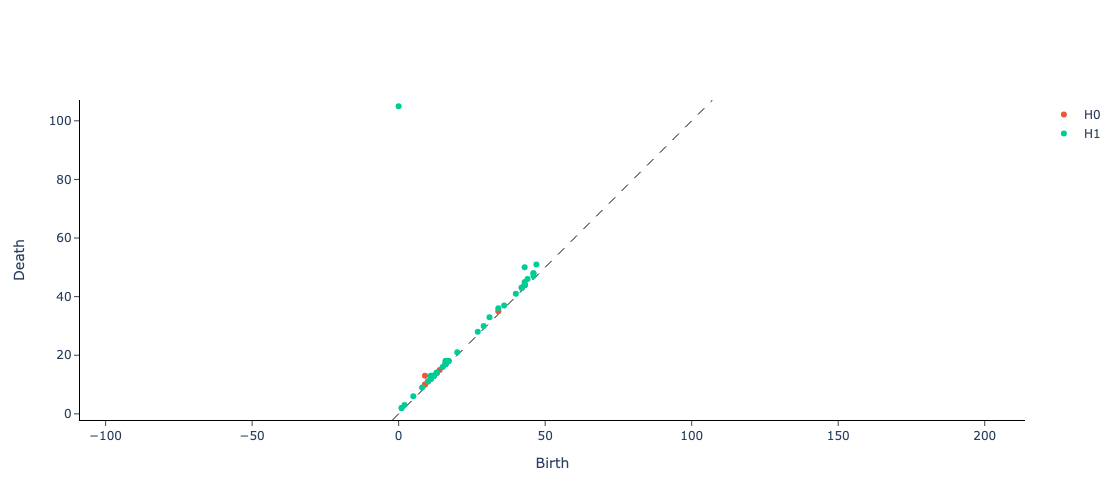

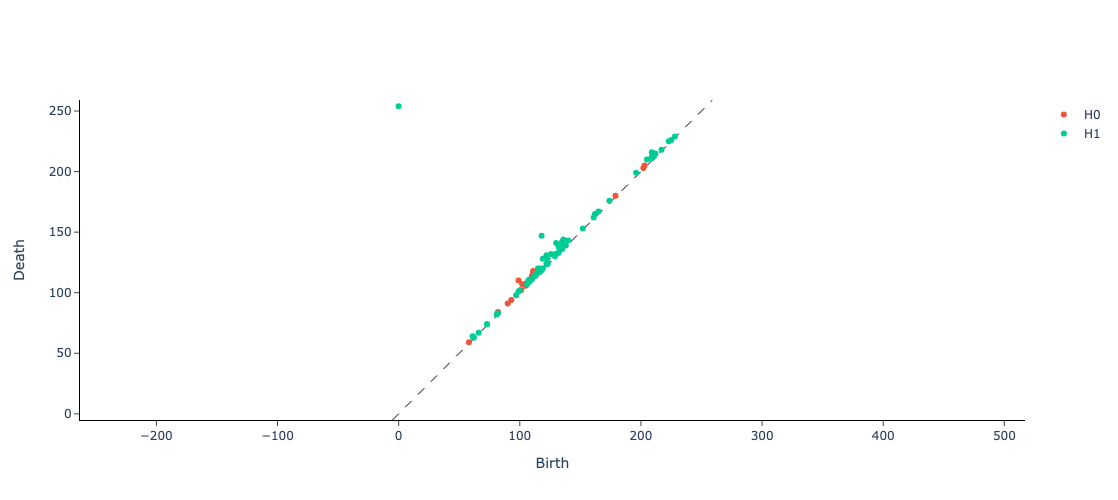

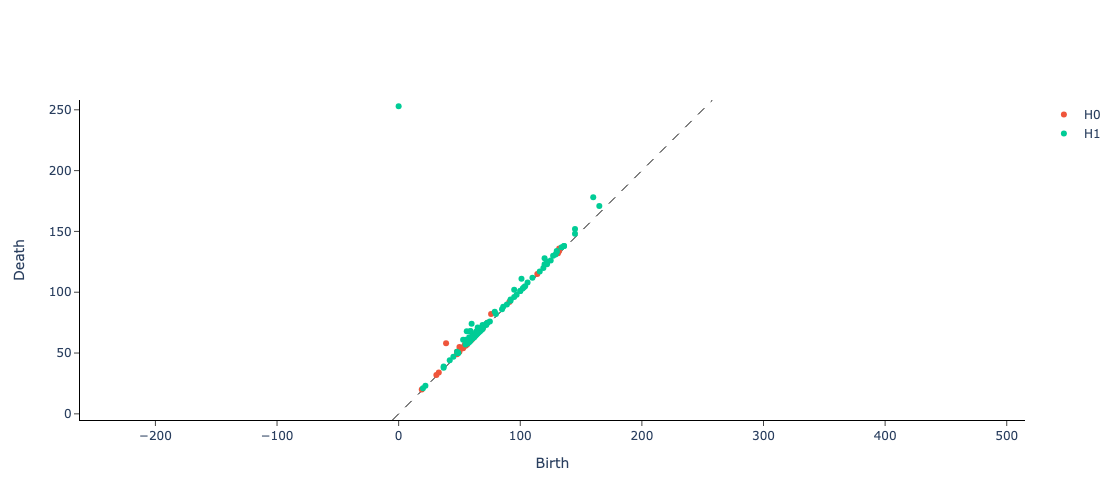

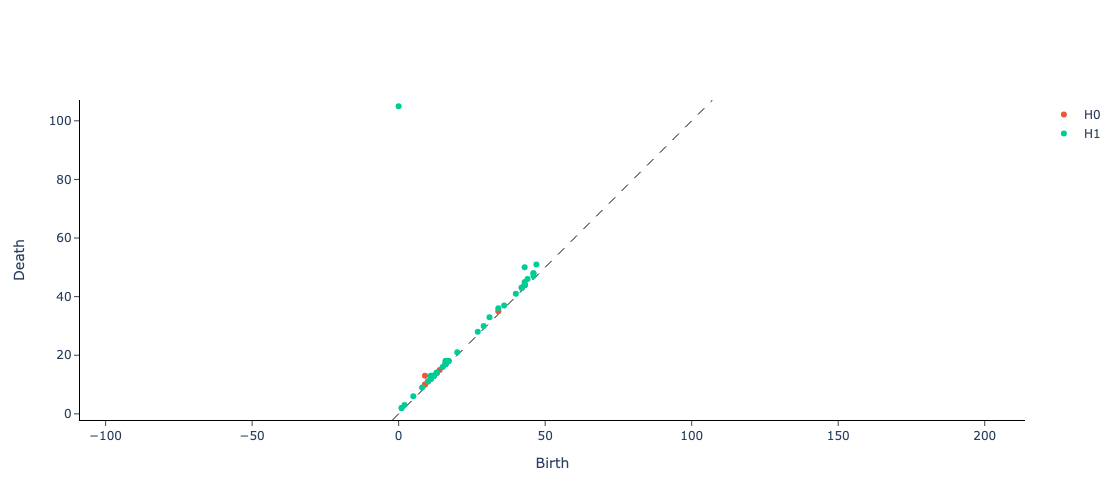

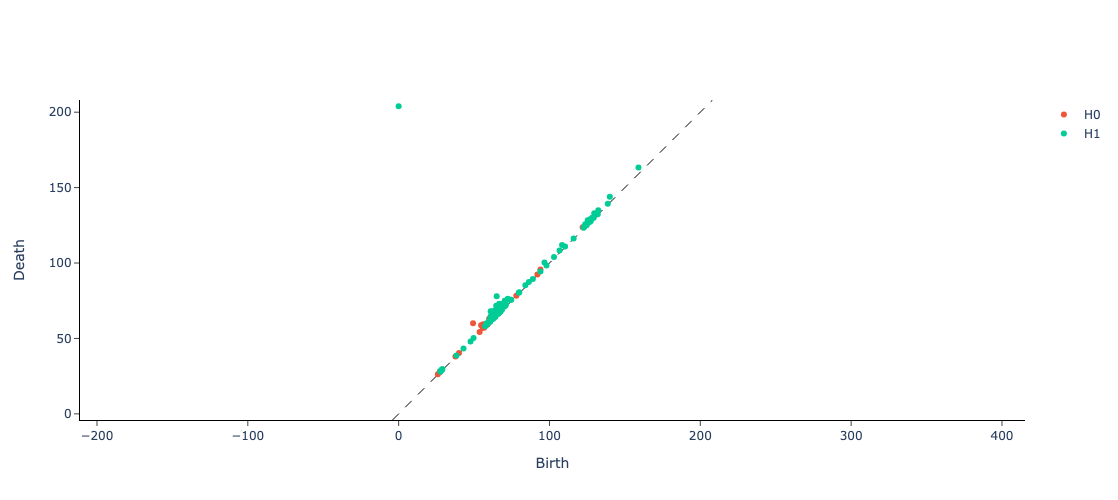

In [209]:
fig1 = plot_diagram(diagrams_RGB[0]) 
fig1.show()

fig2 = plot_diagram(diagrams_R[0])
fig2.show()

fig3 = plot_diagram(diagrams_G[0])
fig3.show()

fig4 = plot_diagram(diagrams_B[0])
fig4.show()

fig5 = plot_diagram(diagrams_gray[0])
fig5.show()

In [271]:
bc = BettiCurve(n_bins = 50)

#100-dim betti features H0 and H1 for each color channel R, G, B and gray
betti_curves_R = bc.fit_transform(diagrams_R)
betti_curves_R_test = bc.fit_transform(diagrams_test_R)

betti_curves_G = bc.fit_transform(diagrams_G)
betti_curves_G_test = bc.fit_transform(diagrams_test_G)

betti_curves_B = bc.fit_transform(diagrams_B)
betti_curves_B_test = bc.fit_transform(diagrams_test_B)

betti_curves_gray = bc.fit_transform(diagrams_gray)
betti_curves_gray_test = bc.fit_transform(diagrams_test_gray)

betti_curves_RGB = bc.fit_transform(diagrams_RGB)
betti_curves_RGB_test = bc.fit_transform(diagrams_test_RGB)

# 400-dim betti features (R,G,B,gray: each 100-dim)
betti_features = np.hstack([betti_curves_R, betti_curves_G, betti_curves_B, betti_curves_gray])  
betti_features_test = np.hstack([betti_curves_R_test, betti_curves_G_test, betti_curves_B_test, betti_curves_gray_test]) 

print(betti_features.shape)
print(betti_features_test.shape)

(864, 8, 50)
(216, 8, 50)


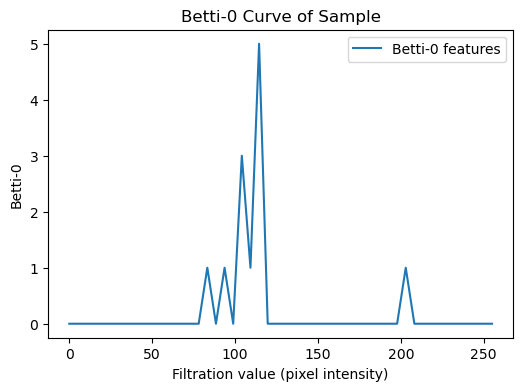

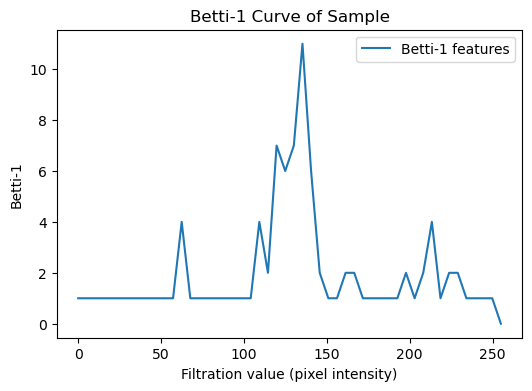

In [272]:
# Plot betti curves 
betti0 = betti_features[0, 0, :]   #Betti-0 curve of sample
betti1 = betti_features[0, 1, :]   #Betti-1

plt.figure(figsize=(6,4))
plt.plot(np.linspace(0, 255, len(betti0)), betti0, label="Betti-0 features")
plt.xlabel("Filtration value (pixel intensity)")
plt.ylabel("Betti-0")
plt.title("Betti-0 Curve of Sample")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(np.linspace(0, 255, len(betti1)), betti1, label="Betti-1 features")
plt.xlabel("Filtration value (pixel intensity)")
plt.ylabel("Betti-1")
plt.title("Betti-1 Curve of Sample")
plt.legend()
plt.show()

In [273]:
#### Training Classification Models #####

In [274]:
# Initializers

y_train_m = y_train.ravel() # (n_samples,)
y_test_m = y_test.ravel()


# Vectorization 

X_vec = betti_features.reshape(betti_features.shape[0], -1)
X_test_vec = betti_features_test.reshape(betti_features_test.shape[0], -1)

print("Test:", X_vec.shape, y_test_m.shape)
print("Train:", X_test_vec.shape, y_train_m.shape)

X_RGB_vec = betti_curves.reshape(betti_curves.shape[0], -1)
X_test_RGB_vec = betti_curve_test.reshape(betti_curve_test.shape[0], -1)


X_R_vec = betti_curves_R.reshape(betti_curves_R.shape[0], -1)
X_R_test_vec = betti_curves_R_test.reshape(betti_curves_R_test.shape[0], -1)

print("Train_R:", X_R_vec.shape, y_train_m.shape)
print("Test_R:", X_R_test_vec.shape, y_test_m.shape)


X_G_vec = betti_curves_G.reshape(betti_curves_G.shape[0], -1)
X_G_test_vec = betti_curves_G_test.reshape(betti_curves_G_test.shape[0], -1)

X_B_vec = betti_curves_B.reshape(betti_curves_B.shape[0], -1)
X_B_test_vec = betti_curves_B_test.reshape(betti_curves_B_test.shape[0], -1)

X_gray_vec = betti_curves_gray.reshape(betti_curves_gray.shape[0], -1)
X_gray_test_vec = betti_curves_gray_test.reshape(betti_curves_gray_test.shape[0], -1)

Test: (864, 400) (216,)
Train: (216, 400) (864,)
Train_R: (864, 100) (864,)
Test_R: (216, 100) (216,)


In [275]:
import numpy as np
np.unique(y_train_m)

num_classes = len(np.unique(y_train_m))

[0]	validation_0-mlogloss:1.55472
[10]	validation_0-mlogloss:1.32263
[20]	validation_0-mlogloss:1.25635
[30]	validation_0-mlogloss:1.24447
[40]	validation_0-mlogloss:1.25123
[50]	validation_0-mlogloss:1.25175
[53]	validation_0-mlogloss:1.26251
XGBoost Accuracy: 0.49074074074074076
              precision    recall  f1-score   support

           0       0.65      0.78      0.71        97
           1       0.30      0.12      0.17        26
           2       0.27      0.27      0.27        41
           3       0.36      0.38      0.37        39
           4       0.17      0.08      0.11        13

    accuracy                           0.49       216
   macro avg       0.35      0.33      0.32       216
weighted avg       0.45      0.49      0.46       216

Multiclass ROC AUC: 0.7175734652994133


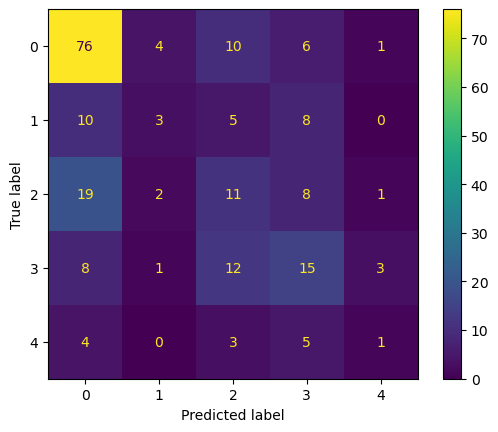

In [276]:
# Train XGBoost model on RetinaMNIST dataset with the original Betti feature vector (400-dim) for each channel

xgb_model = XGBClassifier(
    n_estimators=300,        # number of trees (boosting rounds)
    learning_rate=0.1,       # step size shrinkage
    max_depth=5,             # maximum depth of trees
    subsample=0.8,           # fraction of training samples used per tree
    colsample_bytree=0.8,    # fraction of features used per tree
    random_state=42,
    use_label_encoder=False,
    early_stopping_rounds=20,
    eval_metric="mlogloss",     # <-- multiclass log loss
    objective="multi:softprob", # <-- multiclass classification
    num_class=num_classes  # <-- number of classes in RetinaMNIST
)

# Fit model 
xgb_model.fit(X_vec, y_train_m, eval_set=[(X_test_vec, y_test_m)], verbose=10)

# Predict
y_train_pred = xgb_model.predict(X_vec)
y_train_proba = xgb_model.predict_proba(X_vec)[:, 1] 

y_pred_xgb = xgb_model.predict(X_test_vec)
y_proba_xgb = xgb_model.predict_proba(X_test_vec)

# Multiclass ROC AUC
auc = roc_auc_score(y_test_m, y_proba_xgb, multi_class="ovr", average="macro")


# Evaluate


print("XGBoost Accuracy:", accuracy_score(y_test_m, y_pred_xgb))
print(classification_report(y_test_m, y_pred_xgb))
print("Multiclass ROC AUC:", auc)

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test_m, y_pred_xgb)
plt.show()

In [277]:
# Get the feature importance scores, shap values
#explainer = shap.TreeExplainer(xgb_model)
#shap_values = explainer.shap_values(X_vec)

#shap.summary_plot(shap_values, X_vec, plot_type="bar")

#shap.summary_plot(shap_values, X_vec)

In [278]:

#feature_importances = np.mean([np.abs(sv) for sv in shap_values], axis=0)  # shape: (n_features,)
#top_features_idx = np.argsort(feature_importances)[-100:]
# Flatten 3D data (samples, 50, 5) → (samples, 250)
#X_vec_reduced_flat = X_vec_reduced.reshape(X_vec_reduced.shape[0], -1)
#X_test_vec_reduced_flat = X_test_vec_reduced.reshape(X_test_vec_reduced.shape[0], -1)

# Fit XGBoost
#xgb_model_reduced = XGBClassifier(
 #   n_estimators=300,
 #   max_depth=5,
  #  learning_rate=0.1,
   # subsample=0.8,
  #  colsample_bytree=0.7,
 #   min_child_weight=3,
  #  gamma=1,
   # random_state=42,
  #  use_label_encoder=False,
 #   eval_metric="mlogloss",
  # objective="multi:softprob",
  #  num_class=num_classes,  # total number of classes
  
#early_stopping_rounds=20)


#xgb_model_reduced.fit(
#    X_vec_reduced_flat,
#    y_train_m,
#    eval_set=[(X_test_vec_reduced_flat, y_test_m)],
#    verbose=10)

# Predictions
#y_pred_xgb_reduced = xgb_model_reduced.predict(X_test_vec_reduced_flat)
#y_proba_xgb_reduced = xgb_model_reduced.predict_proba(X_test_vec_reduced_flat)

# Accuracy
#acc = accuracy_score(y_test_m, y_pred_xgb_reduced)
#print("Reduced XGBoost Model Accuracy:", acc)

# Classification report with macro F1
#print(classification_report(y_test_m, y_pred_xgb, zero_division=0))
#macro_f1 = f1_score(y_test_m, y_pred_xgb_reduced, average="macro")
#print("Macro F1-score:", macro_f1)

# Multiclass ROC-AUC
#roc_auc = roc_auc_score(y_test_m, y_proba_xgb_reduced, multi_class="ovr", average="macro")
#print("Multiclass ROC-AUC:", roc_auc)

# Confusion matrix
#ConfusionMatrixDisplay.from_predictions(y_test_m, y_pred_xgb_reduced)
#plt.show()

In [279]:
importance_scores =xgb_model.feature_importances_

In [280]:
selected_features = importance_scores.argsort()[-10:]

In [281]:
reduced_model = XGBClassifier(
    n_estimators=300,        # number of trees (boosting rounds)
    learning_rate=0.1,       # step size shrinkage
    max_depth=5,             # maximum depth of trees
    subsample=0.8,           # fraction of training samples used per tree
    colsample_bytree=0.8,    # fraction of features used per tree
    random_state=42,
    use_label_encoder=False,
    early_stopping_rounds=20,
    eval_metric="mlogloss",     # <-- multiclass log loss
    objective="multi:softprob", # <-- multiclass classification
    num_class=num_classes  # <-- number of classes in RetinaMNIST
)

In [282]:
reduced_model.fit(X_vec[:, selected_features], y_train_m, eval_set=[(X_test_vec[:, selected_features], y_test_m)], verbose=10)

[0]	validation_0-mlogloss:1.55876
[10]	validation_0-mlogloss:1.33959
[20]	validation_0-mlogloss:1.30324
[30]	validation_0-mlogloss:1.30177
[40]	validation_0-mlogloss:1.31260
[48]	validation_0-mlogloss:1.32022


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [283]:
y_pred = reduced_model.predict(X_test_vec[:, selected_features])

print("Reduced XGBoost Accuracy:", accuracy_score(y_test_m, y_pred))

Reduced XGBoost Accuracy: 0.48148148148148145


In [284]:
selector = SelectFromModel(xgb_model, prefit=True)
X_vec_selected = selector.transform(X_vec)
X_test_vec_selected = selector.transform(X_test_vec)

In [285]:
selected_model = XGBClassifier(
    n_estimators=300,        # number of trees (boosting rounds)
    learning_rate=0.1,       # step size shrinkage
    max_depth=5,             # maximum depth of trees
    subsample=0.8,           # fraction of training samples used per tree
    colsample_bytree=0.8,    # fraction of features used per tree
    random_state=42,
    use_label_encoder=False,
    early_stopping_rounds=20,
    eval_metric="mlogloss",     # <-- multiclass log loss
    objective="multi:softprob", # <-- multiclass classification
    num_class=num_classes  # <-- number of classes in RetinaMNIST
)

selected_model.fit(X_vec_selected, y_train_m, eval_set=[(X_test_vec_selected, y_test_m)], verbose=10)

[0]	validation_0-mlogloss:1.55654
[10]	validation_0-mlogloss:1.34255
[20]	validation_0-mlogloss:1.27383
[30]	validation_0-mlogloss:1.26289
[40]	validation_0-mlogloss:1.27768
[43]	validation_0-mlogloss:1.27646


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [286]:
y_pred_selected = selected_model.predict(X_test_vec_selected)
print("Selected XGBoost Accuracy:", accuracy_score(y_test_m, y_pred_selected))

Selected XGBoost Accuracy: 0.47685185185185186


In [287]:
# Check for the imbalanced class case
unique, counts = np.unique(y_train_m, return_counts=True)
print(dict(zip(unique, counts)))

{0: 389, 1: 102, 2: 165, 3: 155, 4: 53}


In [288]:
classes = np.unique(y_train_m)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_m)
class_weights = dict(zip(classes, weights))
sample_weights = np.array([class_weights[y] for y in y_train_m])

In [289]:
xgb_model.fit(X_vec, y_train_m, sample_weight=sample_weights, eval_set=[(X_test_vec, y_test_m)])

[0]	validation_0-mlogloss:1.56572
[1]	validation_0-mlogloss:1.53334
[2]	validation_0-mlogloss:1.50288
[3]	validation_0-mlogloss:1.47944
[4]	validation_0-mlogloss:1.45695
[5]	validation_0-mlogloss:1.43813
[6]	validation_0-mlogloss:1.42180
[7]	validation_0-mlogloss:1.40671
[8]	validation_0-mlogloss:1.39615
[9]	validation_0-mlogloss:1.39040
[10]	validation_0-mlogloss:1.37713
[11]	validation_0-mlogloss:1.36483
[12]	validation_0-mlogloss:1.36359
[13]	validation_0-mlogloss:1.35264
[14]	validation_0-mlogloss:1.34260
[15]	validation_0-mlogloss:1.33595
[16]	validation_0-mlogloss:1.33194
[17]	validation_0-mlogloss:1.32617
[18]	validation_0-mlogloss:1.32155
[19]	validation_0-mlogloss:1.31542
[20]	validation_0-mlogloss:1.30785
[21]	validation_0-mlogloss:1.30397
[22]	validation_0-mlogloss:1.30454
[23]	validation_0-mlogloss:1.30392
[24]	validation_0-mlogloss:1.30477
[25]	validation_0-mlogloss:1.30462
[26]	validation_0-mlogloss:1.30537
[27]	validation_0-mlogloss:1.30421
[28]	validation_0-mlogloss:1.2

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [290]:
y_pred = xgb_model.predict(X_test_vec)
y_proba = xgb_model.predict_proba(X_test_vec)
print("XGBoost Accuracy:", accuracy_score(y_test_m, y_pred))
print(classification_report(y_test_m, y_pred))

XGBoost Accuracy: 0.49074074074074076
              precision    recall  f1-score   support

           0       0.76      0.69      0.72        97
           1       0.38      0.31      0.34        26
           2       0.22      0.24      0.23        41
           3       0.35      0.44      0.39        39
           4       0.29      0.31      0.30        13

    accuracy                           0.49       216
   macro avg       0.40      0.40      0.40       216
weighted avg       0.51      0.49      0.50       216



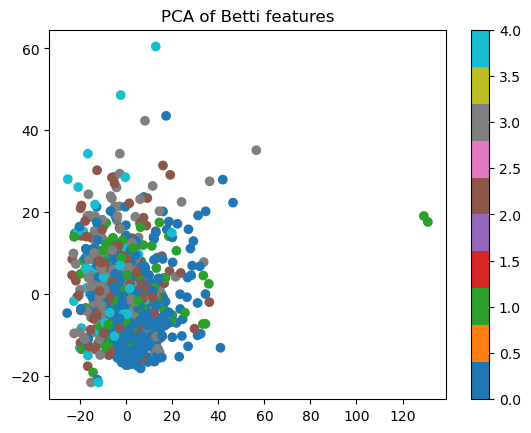

In [291]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_vec)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train_m, cmap='tab10')
plt.colorbar()
plt.title("PCA of Betti features")
plt.show()

In [292]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

In [293]:
# Make sure images are float32
train_images = X_train.astype(np.float32)  # shape: (N,H,W,C)
y_train_m = y_train.ravel()                # or however your labels are stored

test_images = X_test.astype(np.float32)
y_test_m = y_test.ravel()

print("Train images shape:", train_images.shape)
print("Test images shape:", test_images.shape)
print("Train labels shape:", y_train_m.shape)

Train images shape: (864, 64, 64, 3)
Test images shape: (216, 64, 64, 3)
Train labels shape: (864,)


In [294]:
from PIL import Image

def extract_cnn_features(images):
    features = []
    with torch.no_grad():
        for img in images:
            # Convert NumPy array to PIL Image
            img_pil = Image.fromarray(img.astype(np.uint8))
            
            # Apply transforms
            img_tensor = transform(img_pil).unsqueeze(0)  # (1, C, H, W)
            
            # Extract CNN features
            feat = resnet(img_tensor)
            features.append(feat.squeeze().numpy())
    return np.vstack(features)

# Example usage
X_train_cnn = extract_cnn_features(train_images)  # shape: (N_train, 512)
X_test_cnn = extract_cnn_features(test_images)    # shape: (N_test, 512)

In [295]:
X_train_combined = np.hstack([X_vec, X_train_cnn])
X_test_combined = np.hstack([X_test_vec, X_test_cnn])

print("Combined train shape:", X_train_combined.shape)  # should be (N_train, 912)
print("Combined test shape:", X_test_combined.shape)

Combined train shape: (864, 912)
Combined test shape: (216, 912)


In [296]:
classes = np.unique(y_train_m)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_m)
class_weights = dict(zip(classes, weights))

sample_weights = np.array([class_weights[y] for y in y_train_m])

In [297]:
xgb_model_cnn_betti = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    early_stopping_rounds=20,
    eval_metric="mlogloss",
    objective="multi:softprob",
    num_class=len(classes)
)

xgb_model_cnn_betti.fit(
    X_train_combined, y_train_m,
    sample_weight=sample_weights,
    eval_set=[(X_test_combined, y_test_m)],
    verbose=10
)

[0]	validation_0-mlogloss:1.55730
[10]	validation_0-mlogloss:1.27575
[20]	validation_0-mlogloss:1.18221
[30]	validation_0-mlogloss:1.14365
[40]	validation_0-mlogloss:1.12630
[50]	validation_0-mlogloss:1.11849
[60]	validation_0-mlogloss:1.09940
[70]	validation_0-mlogloss:1.10107
[80]	validation_0-mlogloss:1.10381
[81]	validation_0-mlogloss:1.10419


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [298]:
y_pred_cnn_betti = xgb_model_cnn_betti.predict(X_test_combined)
print("Accuracy:", accuracy_score(y_test_m, y_pred_cnn_betti))
print(classification_report(y_test_m, y_pred_cnn_betti))

Accuracy: 0.5601851851851852
              precision    recall  f1-score   support

           0       0.71      0.74      0.73        97
           1       0.41      0.35      0.38        26
           2       0.35      0.32      0.33        41
           3       0.45      0.54      0.49        39
           4       0.67      0.46      0.55        13

    accuracy                           0.56       216
   macro avg       0.52      0.48      0.49       216
weighted avg       0.56      0.56      0.56       216

